In [1]:
import numpy as np
from matplotlib import pyplot as plt
import event_stochastic_ode as eso
import drinking_model as dm

# Coupling the Drinking Model

### Healthy Drinker Model:

$$ \frac{ds}{dt} = s_{\text{slope}}s + m(t) $$

$$ \frac{dp}{dt}  = \gamma[-p + \sigma\,(a s) + b] $$

$$s(t_i) \leftarrow s(t_i) - s_{drink} \quad \text{if } t_i \in e $$

Here, $s(t)$ represents propensity to drink socially, $p(t)$ represents the probability of drinking at time $t$. The function $m(t)$ represents mood, and $e$ is a set of drinking opportunity times. Both $m$ and $e$ are supplied to the model a priori.

### Framework

In [ ]:
class Agent:
    def __init__(self):
        self.state = 0
    def update(dt):
        pass
    


### Model Parameters
We'll start with two people coupled together.

In [47]:
def social_global_update(t, dt, people, adj):
    """ Coupling rule for the social system. You get an opportunity to drink
        if your friends drink.
    """
    d = np.array([y[2] for (f, y, prm, er, e) in people])
    drink_again = adj @ d > 0
    for d_again, p in zip(drink_again, people):
        if d_again:
            f, y, prm, discrf, e = p
            e.append(t + dt)

def coupled_sim(agents, start, end, dt, global_update, global_params, method='rk4'):
    assert start < end
    # Number of timesteps
    N = int((end - start) / dt)
    
    # Create empty state arrays
    agent_states = []
    for ai in agents:
        f, y0, prm, discrf, e = ai
        if type(y0) == float:
            raise InputError("Agent initial condition must be a numpy array")
        else:
            n = len(y0)
        empty_states = np.zeros((N + 1, n))
        empty_states[0, :] = y0
        agent_states.append(empty_states)
    
    # Step forward in time to populate agent_state array
    t = start
    for i in range(1, N):
        for j, aj in enumerate(agents):
            f, y, prm, discrf, e = ai
            y_next, t_next = eso.step(t, dt, f, y, prm, discrf, e, method=method)
            y[:] = y_next
            agent_states[j][i+1, :] = y_next
        global_update(t, dt, agents, *global_params)
        t = t + dt
    t_range = np.arange(start, end, dt)
    return agent_states, t_range            

In [79]:
## Global Parameters
maxdays = 30
start = 0.0
dt = 0.01

## Individual Parameters
# Mood functions
theta1 = 0
theta2 = .25
m1 = lambda t: np.sin(2*np.pi*(t - theta1))
m2 = lambda t: np.sin(2*np.pi*(t - theta2))

# Encounter times
e1 = list(eso.exponential_event_times(maxdays, scale=2.0))
e2 = list(eso.exponential_event_times(maxdays, scale=2.0))

# Social propensity parameters
s_drink1 = 0.5
s_slope1 = -1
s_drink2 = 0.5
s_slope2 = -1

# Drinking probability parameters
a1 = 20.0
b1 = 0.0
gamma1 = 5.0
a2 = 20.0
b2 = 0.0
gamma2 = 5.0

# Package up
params1 = (s_slope1, s_drink1, gamma1, a1, b1, m1)
params2 = (s_slope2, s_drink2, gamma2, a2, b2, m2)

# Initial conditions
y1 = np.zeros(3)
y2 = np.zeros(3)

# People are tuples organized by: (continuous_update_function, current_state, parameters, discrete_update, event_times)
# A class would be useful here, or even a named tuple.
people = [(dm.socialf, y1, params1, dm.social_event_rule, e1), (dm.socialf, y2, params2, dm.social_event_rule, e2)]
global_params = (np.array([[1, 0], [1,0]]),)

print(f"Initial Encounters: \n\tPerson 1: {np.sum(len(e1))} \n\t Person 2: {np.sum(len(e2))}")
states, t = coupled_sim(people, start, maxdays, dt, social_global_update, global_params)
print(f"Total Drinks: \n\tPerson 1: {np.sum(states[0][:,2])}\n\tPerson 2: {np.sum(states[1][:,2])}")
print(f"Total Encounters: \n\tPerson 1: {np.sum(len(e1))} \n\t Person 2: {np.sum(len(e2))}")

Initial Encounters: 
	Person 1: 18 
	 Person 2: 15
Total Drinks: 
	Person 1: 1451.0
	Person 2: 1453.0
Total Encounters: 
	Person 1: 18 
	 Person 2: 15


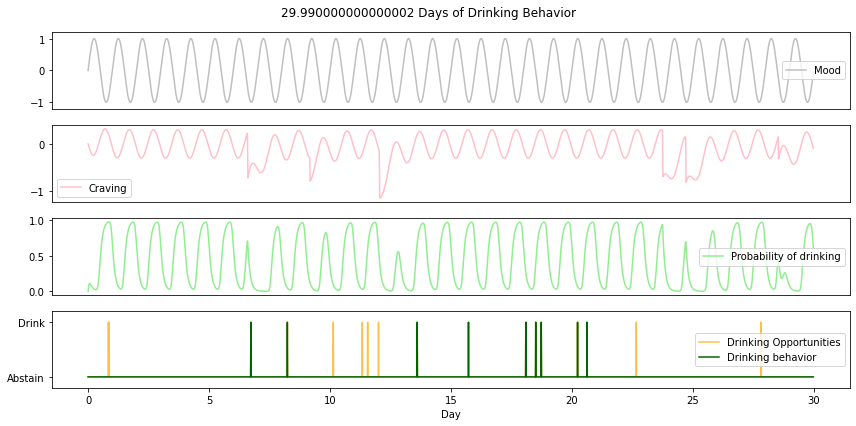

In [80]:
dm.plot_sim(t, states[0][1:,:], e1, params1)

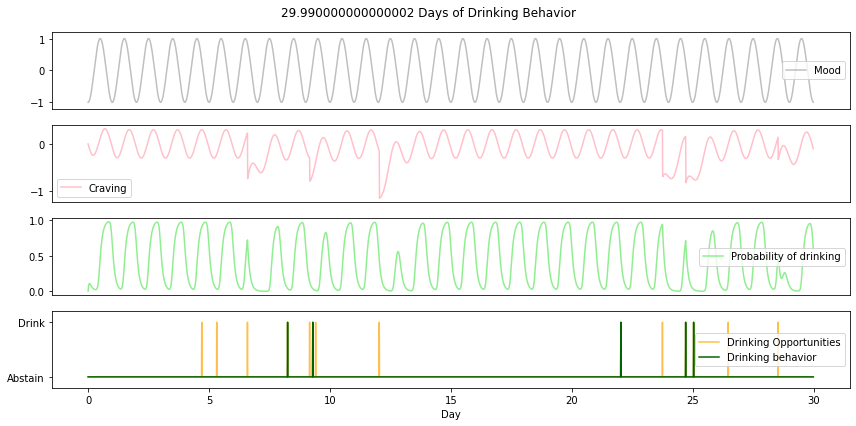

In [81]:
dm.plot_sim(t, states[1][1:,:], e2, params2)